In [1]:
############################################################
# Implementation of the cal_example_zerox.m
# Used to verify the code base works without errors.
############################################################

import numpy as np
import matplotlib.pyplot as plt
import arviz

from mcmc.mcmc import MCMC
from mcmc.data import Data
# from mcmc.chain import Chain
from mcmc.parameter import Parameter

from mcmc.models.kennedyohagan.model1 import Model

# Setup Model

In [2]:
#################
##### MODEL #####
#################

model = Model(
    params={
        'theta': Parameter(
            'theta',
            np.array([0.4]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_eta': Parameter(
            'omega_eta',
            np.array([
                np.exp(-50/4), 
                np.exp(-7/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_delta': Parameter(
            'omega_delta',
            np.array([
                np.exp(-2/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'lambda_eta': Parameter(
            'lambda_eta',
            np.array([1]),
            positive=True,
        ),
        'lambda_delta': Parameter(
            'lambda_delta',
            np.array([30]),
            positive=True,
        ),
        'lambda_epsilon': Parameter(
            'lambda_epsilon',
            np.array([1000]),
            positive=True,
        ),
        'lambda_epsilon_eta': Parameter(
            'lambda_epsilon_eta',
            np.array([10000]),
            positive=True,
        )
    }
)

# Setup Data

In [3]:

################
##### DATA #####
################

DATAFIELD = np.loadtxt('data/simple_field.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/simple_comp.csv', delimiter=',', dtype=np.float32)

xf = np.reshape(DATAFIELD[:, 0], (-1, 1))
xc = np.reshape(DATACOMP[:, 0], (-1,1))
tc = np.reshape(DATACOMP[:, 1], (-1,1))
yf = np.reshape(DATAFIELD[:, 1], (-1,1))
yc = np.reshape(DATACOMP[:, 2], (-1,1))



#Standardize full response using mean and std of yc
yc_mean = np.mean(yc)
yc_std = np.std(yc)
x_min = min(xf.min(), xc.min())
x_max = max(xf.max(), xc.max())
t_min = tc.min()
t_max = tc.max()

xf_normalized = (xf - x_min)/(x_max - x_min)
xc_normalized = (xc - x_min)/(x_max - x_min)
# tc_normalized = np.zeros_like(tc)
# for k in range(tc.shape[1]):
#     tc_normalized[:, k] = (tc[:, k] - np.min(tc[:, k]))/(np.max(tc[:, k]) - np.min(tc[:, k]))
tc_normalized = (tc - t_min)/(t_max - t_min)
yc_standardized = (yc - yc_mean)/yc_std
yf_standardized = (yf - yc_mean)/yc_std

data = Data(
    x_c = xc_normalized, 
    t   = tc_normalized,
    y   = yc_standardized,
    x_f = xf_normalized,
    z   = yf_standardized
)

# Run MCMC

In [4]:
################
##### MCMC #####
################

proposal_widths = {
    'theta': [0.25],
    'omega_eta': [0.000001, 0.3],
    'omega_delta': [0.7],
    'lambda_eta': 0.15,
    'lambda_epsilon_eta': 10000,
    'lambda_delta': 40,
    'lambda_epsilon': 5000
}

mcmc = MCMC(
    max_iter = 5000,
    model = model,
    data = data,
    proposal_widths = proposal_widths
)

mcmc.run()

['theta_0', 'omega_eta_0', 'omega_eta_1', 'omega_delta_0', 'lambda_eta_0', 'lambda_delta_0', 'lambda_epsilon_0', 'lambda_epsilon_eta_0']
Iteration: 0. Log-Posterior: 698.1114547891026
{'theta_0': 0.4, 'omega_eta_0': 3.7266532e-06, 'omega_eta_1': 0.17377394, 'omega_delta_0': 0.60653067, 'lambda_eta_0': 1.0, 'lambda_delta_0': 30.0, 'lambda_epsilon_0': 1000.0, 'lambda_epsilon_eta_0': 10000.0}
Iteration: 50. Log-Posterior: 852.3274787562459
{'theta_0': 0.5211765, 'omega_eta_0': 3.1053426e-06, 'omega_eta_1': 0.39813703, 'omega_delta_0': 0.29748857, 'lambda_eta_0': 0.22250712, 'lambda_delta_0': 33.77023, 'lambda_epsilon_0': 9467.481, 'lambda_epsilon_eta_0': 62430.098}
Iteration: 100. Log-Posterior: 857.5344382999263
{'theta_0': 0.5544755, 'omega_eta_0': 4.3218274e-06, 'omega_eta_1': 0.3880846, 'omega_delta_0': 0.9899998, 'lambda_eta_0': 0.2504014, 'lambda_delta_0': 38.68571, 'lambda_epsilon_0': 7517.8657, 'lambda_epsilon_eta_0': 77356.78}
Iteration: 150. Log-Posterior: 855.0516624803734
{'th

# Analysis

In [5]:
####################
##### ANALYSIS #####
####################

mcmc.chain._chain['theta_0'] = mcmc.chain._chain['theta_0']*(t_max - t_min) + t_min
output = mcmc.chain._chain
for item, value in output.items():
    print(item, np.mean(value), np.min(value), np.max(value))


arviz.summary(mcmc.chain._chain)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


theta_0 0.42541964261826454 0.37546730716234045 0.4759669580430028
omega_eta_0 3.4307326378097967e-06 6.168582444843196e-08 8.707226697879378e-06
omega_eta_1 0.4110302117198706 0.17377394437789917 0.5425211191177368
omega_delta_0 0.7124055978897784 0.0002840154629666358 0.9999792575836182
lambda_eta_0 0.2540530445456505 0.11893977224826813 0.9999153017997742
lambda_delta_0 37.40352748508453 13.778620719909668 79.11829376220703
lambda_epsilon_0 9667.9103 2208.765380859375 20410.478515625
lambda_epsilon_eta_0 79730.6991814453 13812.8330078125 108046.796875


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.425,0.013,0.400,0.448,0.000,0.000,1273.0,1449.0,NaN
omega_eta_0,0.000,0.000,0.000,0.000,0.000,0.000,41.0,84.0,NaN
omega_eta_1,0.411,0.041,0.340,0.487,0.003,0.002,136.0,502.0,NaN
omega_delta_0,0.712,0.296,0.131,1.000,0.021,0.015,114.0,48.0,NaN
lambda_eta_0,0.254,0.060,0.170,0.359,0.005,0.004,118.0,309.0,NaN
lambda_delta_0,37.404,9.956,19.703,55.650,0.339,0.247,905.0,1041.0,NaN
lambda_epsilon_0,9667.910,2952.785,4183.854,15249.315,186.711,143.788,285.0,204.0,NaN
lambda_epsilon_eta_0,79730.699,8591.284,65465.242,96554.289,867.820,615.477,101.0,150.0,NaN


In [6]:
plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

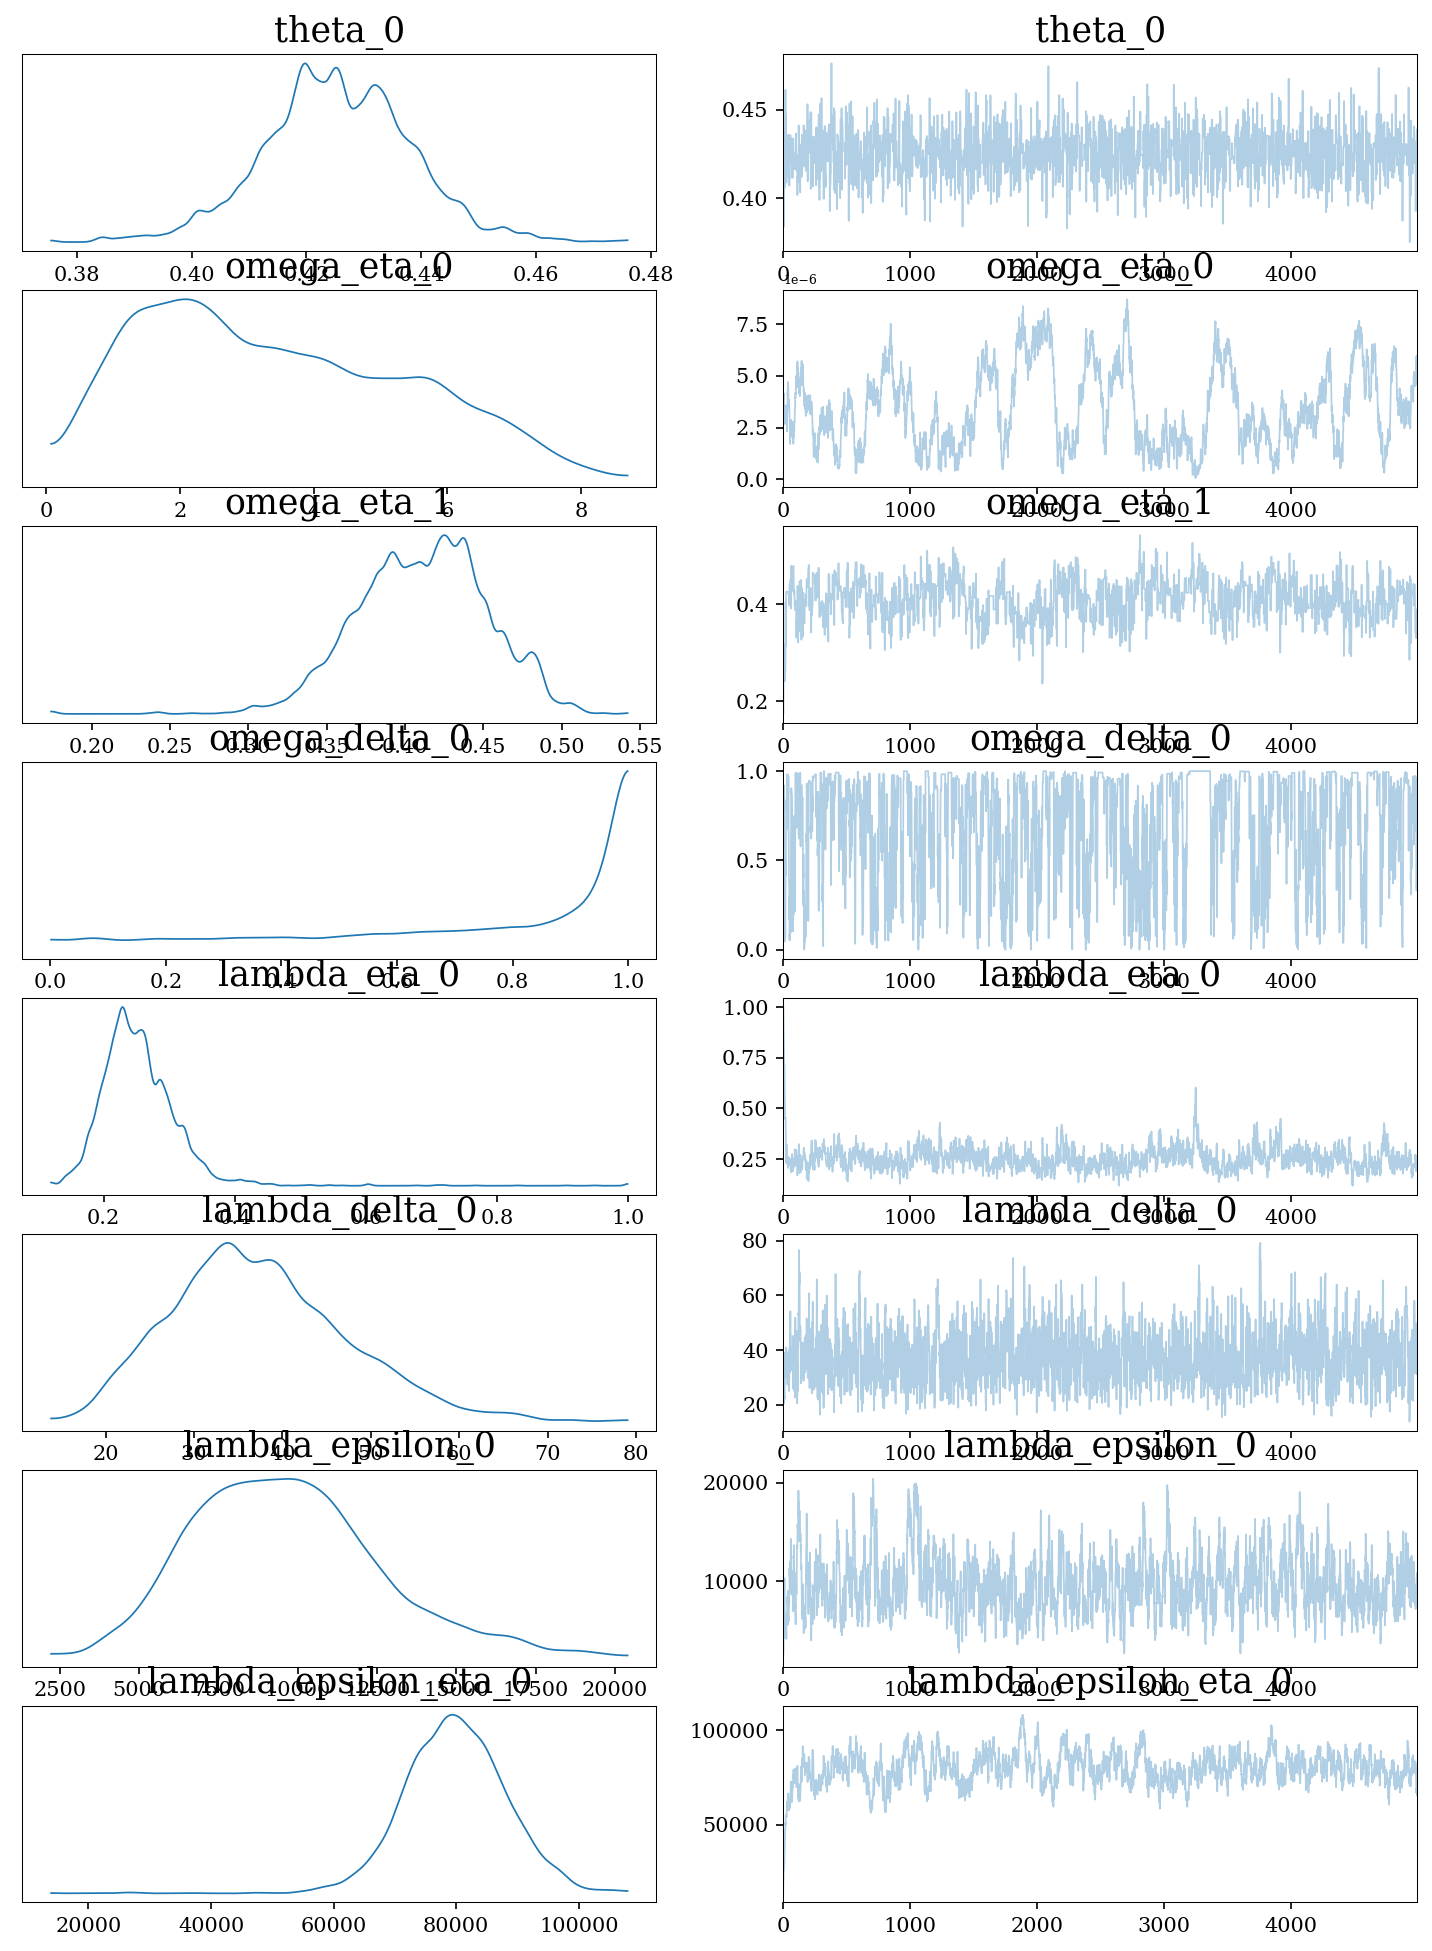

In [7]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        mcmc.chain._chain
    )